<h1>Self Organising Maps for Edinburgh based in SIMD 2016</h1>

This notebook shows the code applied to produce better insights into deprived areas of the City of Edinburgh

In [339]:
#import all the necessary libraries
library(tidyverse)
list.files(path = "../input")
library(kohonen)
library(raster)
library(ggplot2)
library(rgdal)
library(gridExtra)
library(grid)
library(viridis)
library(plyr) 
library(dplyr)
library(plotly)

 

[1] "SG_SIMD_2016_EDINBURGH.dbf" "SG_SIMD_2016_EDINBURGH.prj"
[3] "SG_SIMD_2016_EDINBURGH.sbn" "SG_SIMD_2016_EDINBURGH.sbx"
[5] "SG_SIMD_2016_EDINBURGH.shp" "SG_SIMD_2016_EDINBURGH.shx"

Using Gdal to read the shapfile and transform it to WGS84

In [340]:
edinburgh_shape <- readOGR("../input/SG_SIMD_2016_EDINBURGH.shp", stringsAsFactors = FALSE)
edi_map <- spTransform(edinburgh_shape, CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"))
edi_map$area_sqkm <- area(edi_map) / 1000000


OGR data source with driver: ESRI Shapefile 
Source: "/kaggle/input/SG_SIMD_2016_EDINBURGH.shp", layer: "SG_SIMD_2016_EDINBURGH"
with 597 features
It has 50 fields


The shapefile is not essential for training the data, therefore the attribute will first be extracted from the Shapefile and in a lter step merged together

In [341]:
edi_map@data$id <- rownames(edi_map@data)
edi.df <- edi_map@data
edi.df$pop_area <- round(edi.df$SAPE2014/edi.df$area_sqkm,, digits = 0)

names(edi.df)
head(edi.df)

[1] "DataZone"   "LAName"     "SAPE2014"   "WASAPE2014" "Rank"      
 [6] "Quintile"   "Decile"     "Vigintile"  "Percentile" "IncRate"   
[11] "IncNumDep"  "IncRank"    "EmpRate"    "EmpNumDep"  "EmpRank"   
[16] "HlthCIF"    "HlthAlcSR"  "HlthDrugSR" "HlthSMR"    "HlthDprsPc"
[21] "HlthLBWTPc" "HlthEmrgSR" "HlthRank"   "EduAttend"  "EduAttain" 
[26] "EduNoQuals" "EduNEET"    "EduHESA"    "EduRank"    "GAccPetrol"
[31] "GAccDTGP"   "GAccDTPost" "GAccDTPsch" "GAccDTRet"  "GAccDTSsch"
[36] "GAccPTGP"   "GAccPTPost" "GAccPTRet"  "GAccRank"   "CrimeCount"
[41] "CrimeRate"  "CrimeRank"  "HouseNumOC" "HouseNumNC" "HouseOCrat"
[46] "HouseNCrat" "HouseRank"  "Shape_Leng" "Shape_Area" "Intermedia"
[51] "area_sqkm"  "id"         "pop_area"

,DataZone,LAName,SAPE2014,WASAPE2014,Rank,Quintile,Decile,Vigintile,Percentile,IncRate,⋯,HouseNumNC,HouseOCrat,HouseNCrat,HouseRank,Shape_Leng,Shape_Area,Intermedia,area_sqkm,id,pop_area
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
0,S01008417,City of Edinburgh,726,423,5612,5,9,17,81,0.05,⋯,8,0.023415978,0.011019284,6350,20191.721,10299931.8,Balerno and Bonnington Village,10.3056573,0,70
1,S01008418,City of Edinburgh,710,396,6285,5,10,19,91,0.01,⋯,10,0.010115607,0.014450867,6650,25944.862,23570497.5,Balerno and Bonnington Village,23.5838156,1,30
2,S01008419,City of Edinburgh,526,326,5717,5,9,17,82,0.04,⋯,0,0.060000000,0.000000000,5373,5738.935,1366456.9,Balerno and Bonnington Village,1.3672367,2,385
3,S01008420,City of Edinburgh,488,287,6737,5,10,20,97,0.04,⋯,0,0.004201681,0.000000000,6957,1890.097,105196.7,Balerno and Bonnington Village,0.1052565,3,4636
4,S01008421,City of Edinburgh,885,542,3530,3,6,11,51,0.12,⋯,6,0.071095571,0.006993007,4598,2645.609,146544.1,Balerno and Bonnington Village,0.1466273,4,6036
5,S01008422,City of Edinburgh,622,345,6792,5,10,20,98,0.01,⋯,4,0.027375201,0.006441224,6377,3329.511,231579.9,Balerno and Bonnington Village,0.2317112,5,2684


Due to the fact that all domain ranks are in a ordinal scale and that inherits a lost of information, each domain will get a new column that exists of all variables of the domain normalized to 0 to 1 and then added. Where varibales are just another expression of the same meaning like rate and abolsute number only the rate is considered.

In [342]:
normalize <- function(x){(x-min(x))/(max(x)-min(x))}

#Health

Health.df <- dplyr::select(edi.df,HlthCIF,HlthAlcSR,HlthDrugSR,HlthSMR,HlthDprsPc,HlthLBWTPc,HlthEmrgSR) %>% apply(2, normalize) %>% data.frame()
Health <- rowSums(Health.df)
edi.df$Health <- Health
# a high value in Health means deprived
#Education

Education.df <- dplyr::select(edi.df,EduAttend,EduAttain,EduNoQuals,EduNEET,EduHESA) %>% apply(2, normalize) %>% data.frame()
Education <- (1-Education.df$EduAttend) + (1-Education.df$EduAttain) +Education.df$EduNoQuals+Education.df$EduNEET + (1-Education.df$EduHESA)
edi.df$Education <- Education
# a high value in Education means deprived

#Access

Access.df <- dplyr::select(edi.df,GAccPetrol,GAccDTGP,GAccDTPost,GAccDTPsch,GAccDTRet,GAccDTSsch,GAccPTGP,GAccPTPost,GAccPTRet) %>% apply(2, normalize) %>% data.frame()
Access <- rowSums(Access.df) 
edi.df$Access <- Access
# a high value in Access means deprived

#Housing

Housing.df <- dplyr::select(edi.df,HouseOCrat,HouseOCrat) %>% apply(2, normalize) %>% data.frame()
Housing <- rowSums(Housing.df)
edi.df$Housing <- Housing
# a high value in Housing means deprived
nrow(edi.df)


[1] 597

    
<h3>This are the column names, we can choose from for the SOM</h3>
Please see for specifcation teh documentation

* Pop: 'DataZone','LAName','SAPE2014','WASAPE2014','Pop_area'
* Rank: 'Rank','Quintile','Decile','Vigintile','Percentile'
* Income: 'IncRate','IncNumDep','IncRank'
* Employment: 'EmpRate','EmpNumDep','EmpRank'
* Health: 'HlthCIF','HlthAlcSR','HlthDrugSR','HlthSMR','HlthDprsPc','HlthLBWTPc','HlthEmrgSR','HlthRank'
* Education: 'EduAttend','EduAttain','EduNoQuals','EduNEET','EduHESA','EduRank'
* Access: 'GAccPetrol','GAccDTGP','GAccDTPost','GAccDTPsch','GAccDTRet','GAccDTSsch','GAccPTGP','GAccPTPost','GAccPTRet','GAccRank'
* Crime: 'CrimeCount','CrimeRate','CrimeRank'
* Housing: 'HouseNumOC','HouseNumNC','HouseOCrat','HouseNCrat','HouseRank'
* Geomtry: 'Shape_Leng','Shape_Area','Intermedia''id',Area_sqrt'

Select variables to gain insights of its distribution and dependency on others


In [344]:
set.seed(123) #make process repreatable and same
#set the variables, that are interesting
data_train <- dplyr::select(edi.df, EmpRate, Education, Access, Housing)
#Wealth,HouseOCrat,HouseNCrat,GAccRank
#scale data , GAccRank,CrimeRank, HouseRank,

data_train_matrix <- as.matrix(scale(data_train))
names(data_train_matrix) <-(data_train)
rows <- nrow(data_train_matrix)
rows
#determine the size of the grid by determing that ideally 10 observations are in one node
xy <- round(sqrt(5*sqrt(rows)), digits = 0)
xy


[1] 597

[1] 11

This function will initilazie the SOM model and train the data

In [345]:
som_grid <- somgrid(xdim = xy, ydim=xy, topo="hexagonal")
som_model <-som(data_train_matrix,
               grid=som_grid,
               rlen=1500,
               alpha=c(0.5,0.01),
               keep.data= TRUE)


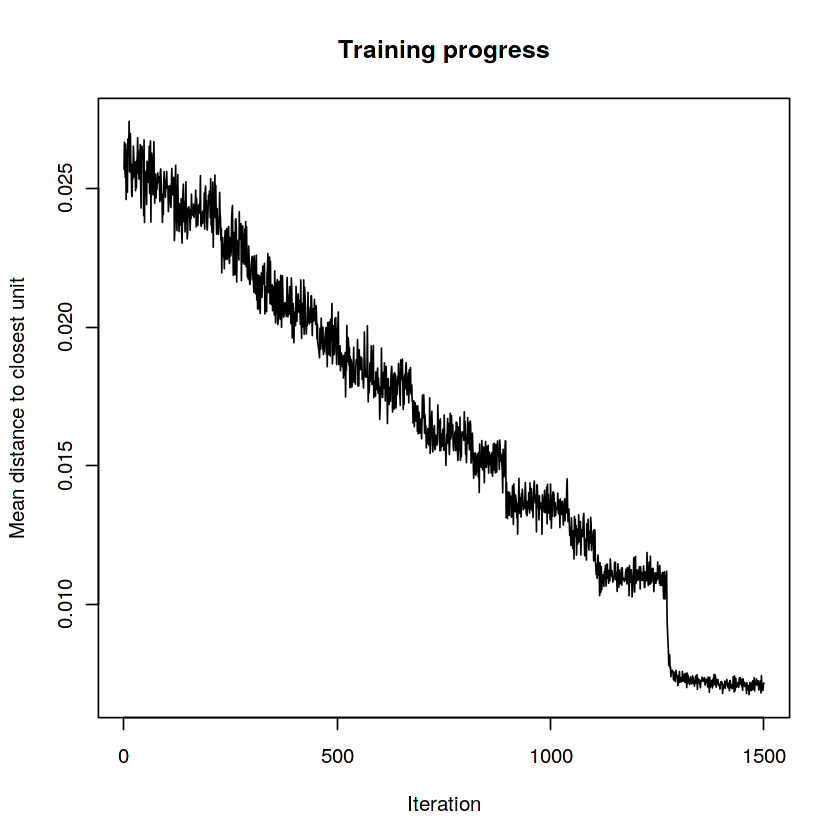

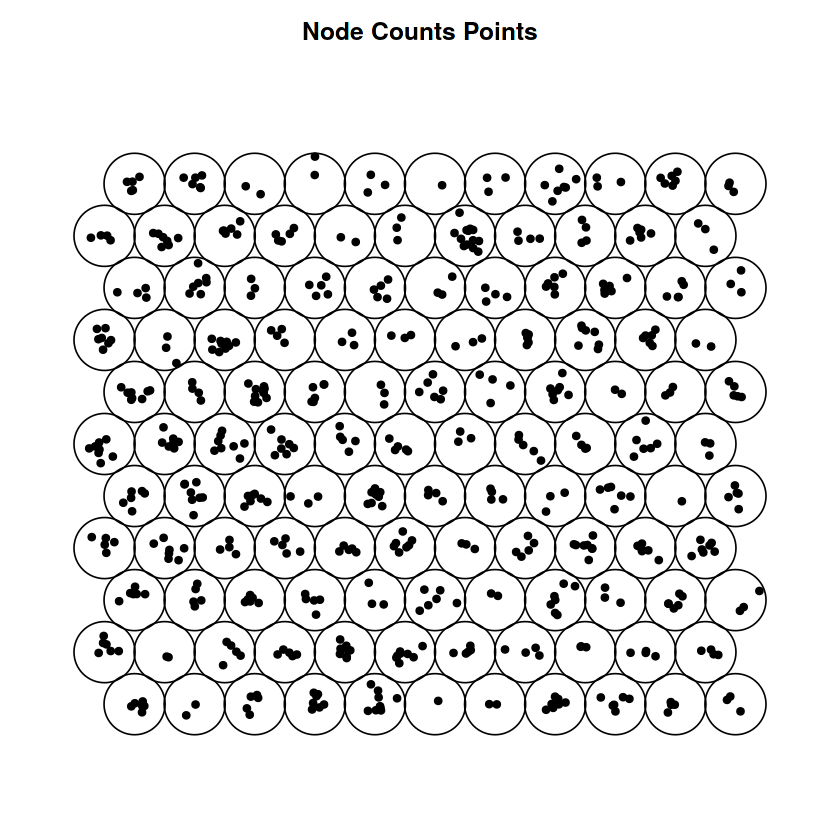

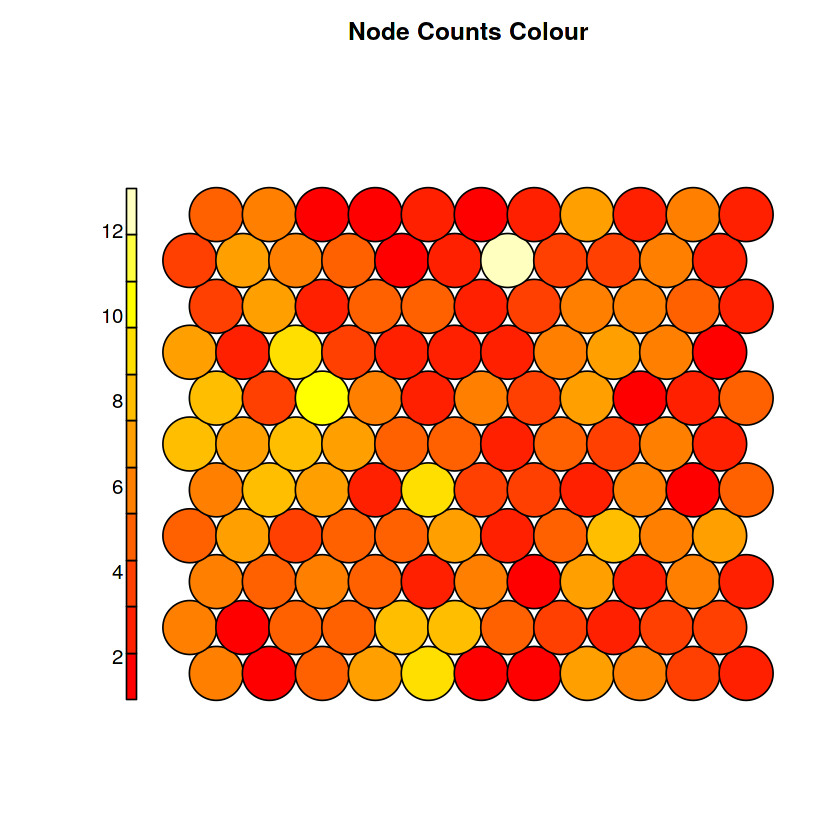

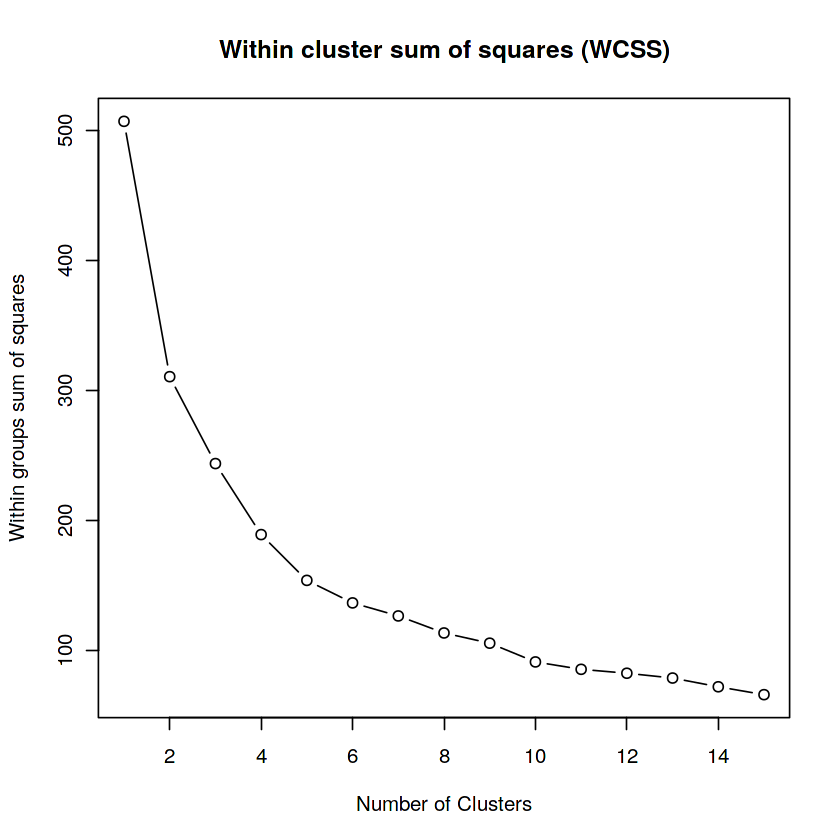

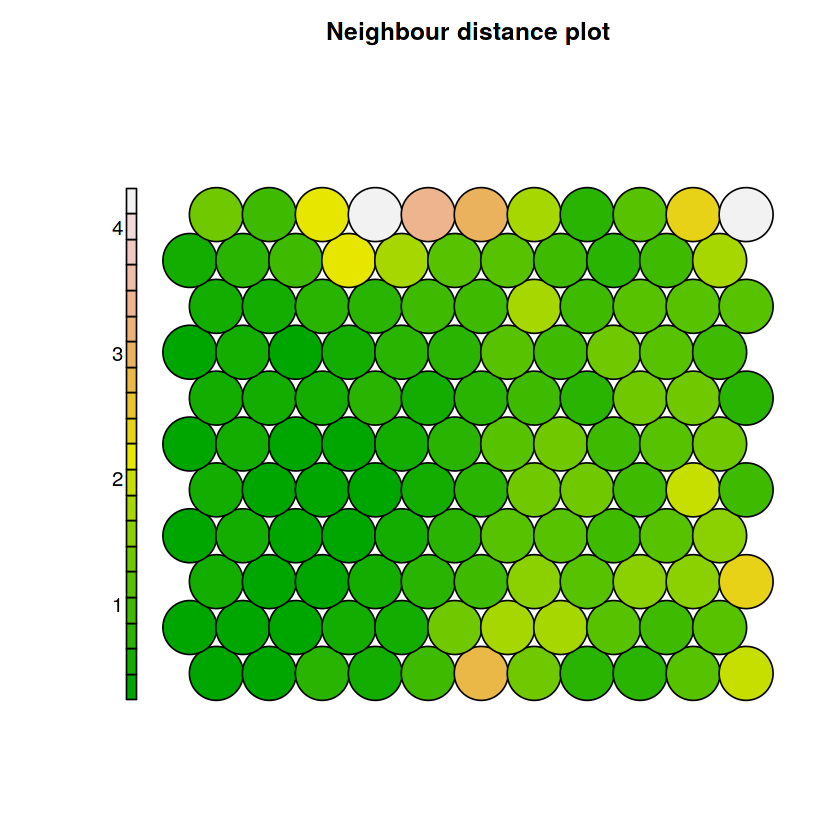

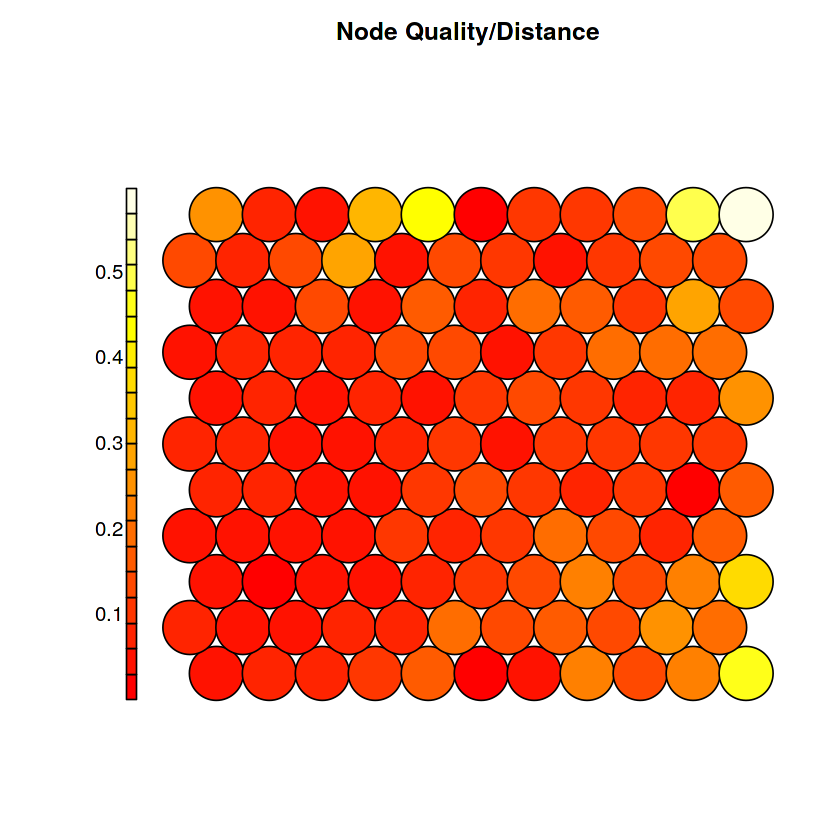

In [346]:
mydata <- getCodes(som_model)
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var))
for (i in 2:15) wss[i] <- sum(kmeans(mydata, centers=i)$withinss)

plot(som_model, type="changes")
plot(som_model, type = "mapping", pchs = 20, main = "Node Counts Points")

plot(som_model,type="counts",main="Node Counts Colour")
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares", main="Within cluster sum of squares (WCSS)")

#map quality 
library('IRdisplay')
fig <- plot_ly(data = as.data.frame(som_model[["grid"]][["pts"]]),
        z = as.matrix(dist(getCodes(som_model))))
fig <- fig %>% add_surface()
htmlwidgets::saveWidget(fig, "p10.html")
display_html('')

plot(som_model, type = "dist.neighbours", palette.name = terrain.colors)
plot(som_model, type = "quality", main="Node Quality/Distance")

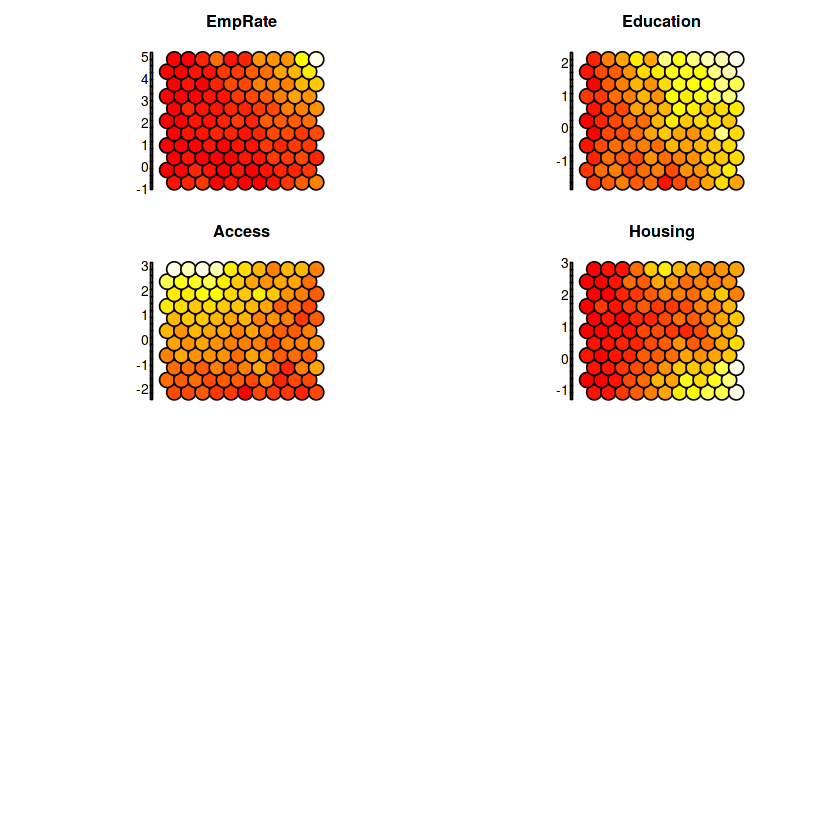

In [347]:
par(mfrow=c(4,2)) #this tells R to put 2 plots in each column and row 
plot(som_model, type = "property", property = getCodes(som_model)[,1], main=colnames(getCodes(som_model))[1])
plot(som_model, type = "property", property = getCodes(som_model)[,2], main=colnames(getCodes(som_model))[2])
plot(som_model, type = "property", property = getCodes(som_model)[,3], main=colnames(getCodes(som_model))[3])
plot(som_model, type = "property", property = getCodes(som_model)[,4], main=colnames(getCodes(som_model))[4])
#plot(som_model, type = "property", property = getCodes(som_model)[,5], main=colnames(getCodes(som_model))[5])
#plot(som_model, type = "property", property = getCodes(som_model)[,6], main=colnames(getCodes(som_model))[6])
#plot(som_model, type = "property", property = getCodes(som_model)[,7], main=colnames(getCodes(som_model))[7])

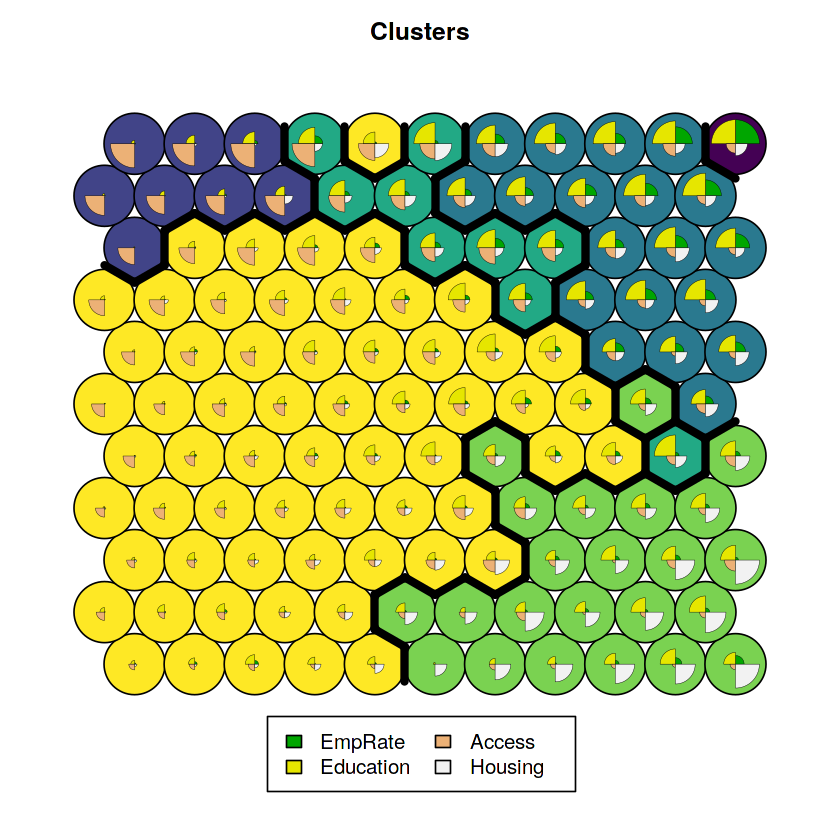

In [348]:
som_cluster <- cutree(hclust(dist(getCodes(som_model))),6)
my_viridis6x <- c("#440154", "#414488", "#2A798F", "#22A985", "#7AD251", "#FEE825")
my_viridis6 <- c("#FEE825", "#7AD251","#22A985","#2A798F","#414488" ,"#440154")
my_viridis8 <- c("#FEE825" , "#9FDB3A", "#4AC26E", "#1FA288", "#27808F", "#365C8D", "#46327F", "#440154")
my_viridis10 <-c("#FEE825","#B5DE2C", "#6DCF5A", "#35B879", "#1F9E89", "#26838F", "#31688E", "#3E4A8A", "#482878", "#440154")
plot(som_model, type="codes", bgcol = my_viridis6[som_cluster], main = "Clusters")
add.cluster.boundaries(som_model, som_cluster)

In [349]:
cluster_details <- data.frame(id=edi.df$id,
                              cluster=som_cluster[som_model$unit.classif])

In [350]:
ed <- fortify(edinburgh_shape)
mappoints <- merge(ed, cluster_details, by="id")

Regions defined for each Polygons



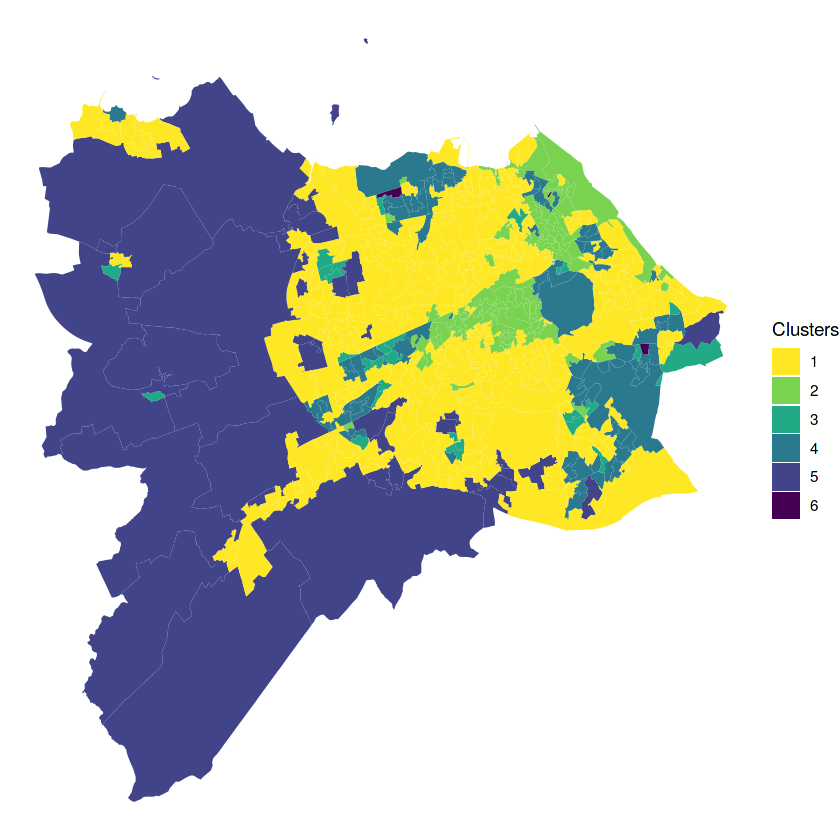

In [351]:
ggplot(data=mappoints, aes(x=long, y=lat, group=group, fill=factor(cluster))) +
geom_polygon(colour="transparent") + 
theme_void() +
#coord_equal() +
scale_fill_manual(name = "Clusters", values = my_viridis6)

Now I will try a supervised classifcation

In [352]:
mappoints <- merge(edi_map, cluster_details, by="id")
#write our ireland_map as an esri shapefile
writeOGR(obj=mappoints,
         dsn="edi_all_domains",
         layer="edi_all_domains",
         driver="ESRI Shapefile")

ERROR: Error in writeOGR(obj = mappoints, dsn = "edi_all_domains", layer = "edi_all_domains", : layer exists, use a new layer name


In [ ]:
#set.seed(123)
#ind <- sample(2,nrow(data_train), replace = T, prob= c(0.7,0.3))
#train <- data_train[ind == 1,]
#test <- data_train[ind == 2,]
#trainX <- scale(train[])
#testX <- scale(test[],
 #             center = attr(trainX, "scaled:center"),
 #             scale = attr(trainX, "scaled:scale"))

#cbPalette <- c("#d5f4e6", "#80ced6", "#fefbd8", "#618685", "#36486b", "#4040a1","#b2b2b2", "#f4e1d2" )
##yellowred <- c("#e4062e","#e80705","#ec3105","#f05e04","#f48c03","#f8bc02","#fced02", "#e4062e")
##variouscolours <- c("#cd6155","#af7ac5","#5499c7","#48c9b0","#52be80","#f4d03f","#eb984e","#cacfd2")
#variouscolours6 <- c("#cd6155","#af7ac5","#5499c7","#48c9b0","#52be80","#f4d03f")
#variouscolours <- c("#cd6155","#af7ac5","#5499c7","#48c9b0","#52be80","#f4d03f","#eb984e","#cacfd2")
#cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00" )